# MOT16: A Benchmark for Multi-Object Tracking

Original paper: https://arxiv.org/pdf/1603.00831.pdf

## Annotation Rules

* **Targets**: All upgright people including
    * walking, standing, running pedestrains
    * cyclists, skaters
    
    
* **Distractors**: Static people or representations
    * people not int upgright position (sitting, lying down)
    * reflections, drawings or photographs of people
    * human-like objects like dolls, manneqins


* **Others**: Moving vehicles and occluders
    * Cars, bikes, motorbikes
    * Pillars trees, building
    
### Y-detection 

| Position  | Name | Description |
| ------------- | ------------- | ---------- |
| 0  | Frame number  | Indicates at which frame the object is present  |
| 2  | Bounding box left  | Coors of top-left corner of pedestrian bb |
| 3  | Bounding box top  | Coors of top-left corner of pedestrian bb |
| 4  | Bounding box width  | Coors of top-left corner of pedestrian bb |
| 5  | Bounding box height  | Coors of top-left corner of pedestrian bb|
| 6  | Confidence score | Indicates how confident the detector is that this instance is a pedestrian |

Positions that are not described yield no function and can be ignored

### Y-ground-truth

| Position  | Name | Description |
| ------------- | ------------- | ---------- |
| 0  | Frame number  | Indicates at which frame the object is present  |
| 1  | Identity number | Each pedestrian trjaectory is identified by a unique ID |
| 2  | Bounding box left  | Coors of top-left corner of pedestrian bb |
| 3  | Bounding box top  | Coors of top-left corner of pedestrian bb |
| 4  | Bounding box width  | Coors of top-left corner of pedestrian bb |
| 5  | Bounding box height  | Coors of top-left corner of pedestrian bb|
| 6  | Confidence score | Flag wheather the entry is to be considered (1) or ignored (0) |
| 7  | Class | Indicates the type of object annotated
| 8  | Visibility | Visibility ratio, [0, 1], that says how much of that object is visible |

In [1]:
import json
from pprint import pprint
Settings = json.load(open('settings.txt'))
pprint(Settings)

{'data_root': '/home/data'}


## Settings:

need to be a text file **settings.txt** in this very folder with following content:

```javascript
{
    "data_root": '/where/your/data/is/stored'
}
```

In [2]:
%matplotlib inline

import sys
sys.path.insert(0,'../')
from pak import datasets
from pak import utils
import matplotlib.pyplot as plt

root = Settings['data_root']

frame = 1
resize = 0.5

mot16 = datasets.MOT16(root)

# the training set contains both detection as well as ground-truth data
# while the test set only contains detection data.
X, Y_det, Y_gt = mot16.get_train("MOT16-02", memmapped=True)

/home/data/MOT16 found :)
MOT16: load memmapped file /home/data/MOT16/train/MOT16-02/data.memmap
MOT16 X loaded
MOT16 Y_det loaded
MOT16 Y_gt loaded


In [3]:
X_ = X[0:10]

def get_visible_pedestrains(frame):
    Y_gt_frame1 = utils.extract_eq(Y_gt, col=0, value=frame)
    Y_gt_frame1 = utils.extract_eq(Y_gt_frame1, col=7, value=1)
    Y_gt_frame1 = utils.extract_eq(Y_gt_frame1, col=8, value=1)
    return Y_gt_frame1

frame = 120

import numpy as np
from math import sqrt

D = []
for i in range(10):
    D.append(get_visible_pedestrains(i+1))

D = np.concatenate(D).astype('int64')


def calculate_cost(one, two):
    f1, pid1, x1, y1, bb_w1, bb_h1, _, _, _ = one
    f2, pid2, x2, y2, bb_w2, bb_h2, _, _, _ = two
    
    h = (bb_h1 + bb_h2) / 2.0
    f_st =  sqrt((x1 - x2)**2 + (y1 - y2)**2) / h
    
    f_st += 1e-10
    ce = - np.log((1- np.exp(-f_st))/np.exp(-f_st))
    
    return ce
        

def calculate_adj_list(Table, dst_theta=3):
    n, _ = Table.shape
    
    edges = []
    lifted_edges = []
    
    for i, entry in enumerate(Table):
        f, pid, bb_left, bb_right, bb_w, bb_h, _, _, _ = entry
        
        for j in range(i+1, n):
            f_o, pid_o, bb_left_o, bb_right_o, bb_w_o, bb_h_o, _, _, _ = Table[j]
            
            cost = calculate_cost(entry, Table[j])
            #print('cost:', cost)
            
            if abs(f_o - f) > dst_theta:
                # lifted edge
                lifted_edges.append((i,j,cost))
            else:
                # normal edge
                edges.append((i,j,cost))
                
    edges = np.array(edges)
    lifted_edges = np.array(lifted_edges)
    
    print('Edges', edges.shape)
    print('Lifted Edges', lifted_edges.shape)
    
    fmt = '%d %d %f'
    
    np.savetxt('edges.txt', edges, delimiter=';', fmt=fmt)
    np.savetxt('lifted_edges.txt', lifted_edges, delimiter=';', fmt=fmt)
    
    with open('config.txt', 'w+') as f:
        print(str(n), file=f)
    
                
print(D.shape)
calculate_adj_list(D)
#print(D)

(50, 9)
Edges (700, 3)
Lifted Edges (525, 3)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


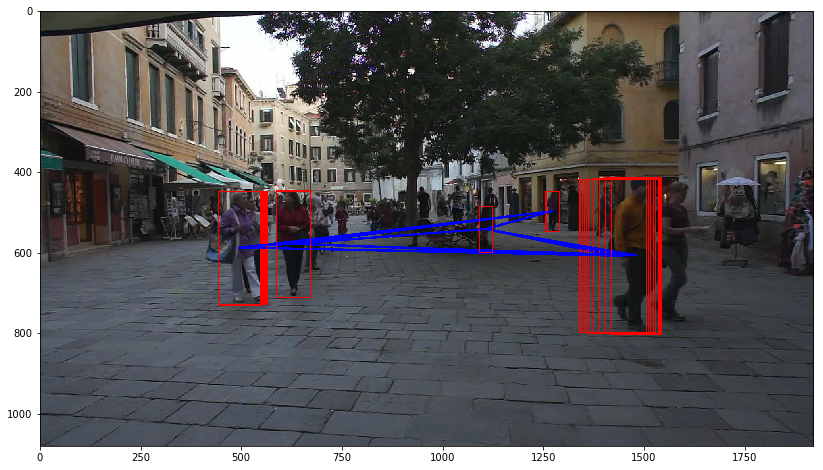

In [4]:
from numpy import genfromtxt
result = genfromtxt('result.txt', delimiter=' ', dtype='uint32')

def extract_ids(result):
    #TODO: make this stuff better..
    
    candidates = []
    n = np.max(result[:,1])  # total number of nodes
    
    Nodes = [i for i in range(n+1)]
    
    
    for i, j, edge in result:
        assert(i < j)
        has_edge = edge == 1
        
        if has_edge:
            repres = Nodes[i]
            Nodes[j] = repres

    print(Nodes)     
            
        

extract_ids(result)

def get_bb(i, D):
    left = D[i,2]
    top = D[i,3]
    width = D[i,4]
    height = D[i,5]
    return left, top, width, height

def get_line(i, j, D):
    x1,y1,w1,h1 = get_bb(i, D)
    x2,y2,w2,h2 = get_bb(j, D)
    
    center = lambda x,y,w,h: (x+(w/2), y+(h/2))
    
    A = center(x1,y1,w1,h1)
    B = center(x2,y2,w2,h2)
    return [A[0], B[0]], [A[1], B[1]]


fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
ax.imshow(X_[-1])

# for i in range(50):
#     l,t,w,h = get_bb(i, D)
#     bbX, bbY = utils.bb_to_plt_plot(l, t, w, h)
#     ax.plot(bbX, bbY, linewidth=1, color='red')

for i, j, edge in result:
    assert(i < j)
    has_edge = edge == 1
    
    l,t,w,h = get_bb(i, D)
    bbX, bbY = utils.bb_to_plt_plot(l, t, w, h)
    ax.plot(bbX, bbY, linewidth=1, color='red')
    
    lj,tj,wj,hj = get_bb(j, D)
    bbX, bbY = utils.bb_to_plt_plot(lj, tj, wj, hj)
    ax.plot(bbX, bbY, linewidth=1, color='red')
    
    if has_edge:
        lx, ly = get_line(i,j,D)
        ax.plot(lx, ly, linewidth=1, color='blue')

#cur = utils.extract_eq(D, col=0, value=10)


plt.show()